# Проект: Временные ряды

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


**Цель исследования:**
1. Построить модель для прогнозирования количество заказов такси на следующий час.

**Ход исследования**

Данные получим из файла `/datasets/taxi.csv` сделаем ресемплирование по одному часу.

просмотрим общую информацию о датасете, оценим качество данных.

Далее проанализируем данные.

После этого применим пайплайн для подготовки признаков и обучения моделей.

Завершающим этапом исследования будет выбор лучшей модели и проверка на тестовой выборке.

Таким образом, иследование будет состоять из следующих этапов:

- [Обзор данных](#info)

- [Анализ данных](#analysis)

- [Подготовка данных](#preprocessing)

- [Обучение модели](#model)

- [Тестирование модели](#testing)

- [Итоговые выводы](#final)

## Описание данных
Данные находятся в файле `/datasets/taxi.csv`

Количество заказов находится в столбце `num_orders` (от англ. number of orders, «число заказов»).

In [1]:
# Устанавливаем и обновляем необходимые библиотеки
!pip install -Uq scikit-learn phik 

In [2]:
# Импротируем необходимые библиотеки
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from numpy.random import RandomState
sns.set()

import sklearn
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Зафиксируем случайность  и размер тестовой выборки
RANDOM_STATE = 42
TEST_SIZE = 0.1
state = RandomState(12345)

sklearn.__version__, lightgbm.__version__


('1.6.1', '3.3.1')

### **Общая информация**
<a id='info'></a>

In [3]:
# Загружаем файл
pth1 = '/datasets/taxi.csv'
pth2 = 'taxi.csv'
    
if os.path.exists(pth1):
    taxi = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    taxi = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [4]:
# Cделаем ресемплирование по одному часу
taxi = taxi.resample('1H').sum()

In [5]:
# Создаем функцию для получения общей информации
def general_info(df):
    return df.info(), display(df.shape, df.head(), df.index.is_monotonic)

In [6]:
# Посмотрим на первые 5 строк датасета и общую информацию
general_info(taxi)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


(4416, 1)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


True

(None, None)

**Вывод:** Датафрейм содержит **4416 строк и 1 столбец**.

В данных пропуски отсутствуют, типы данных корректны, даты и время расположены в хронологическом порядке. Мы имеем дело с данными от 1 марта 2018 до 31 августа 2018 года.

### **Анализ данных**
<a id='analysis'></a>

Посмотрим на график заказов такси.

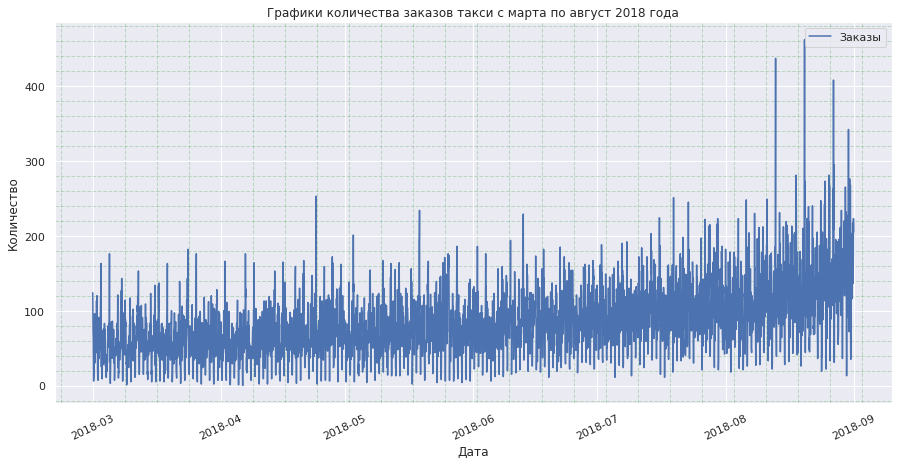

In [7]:
plt.figure(figsize=(15,7))
sns.lineplot(data=taxi, x=taxi.index, y='num_orders', label='Заказы')
plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
plt.minorticks_on()
plt.tick_params(which='minor')
plt.xticks(rotation = 25)
plt.title(f'Графики количества заказов такси с марта по август 2018 года')
plt.xlabel('Дата')
plt.ylabel('Количество');

Мы видим, что во временном ряду присутствуют колебания.

Построим функцию автокорреляции, чтобы определить оптимальное количество лагов и размер окна.

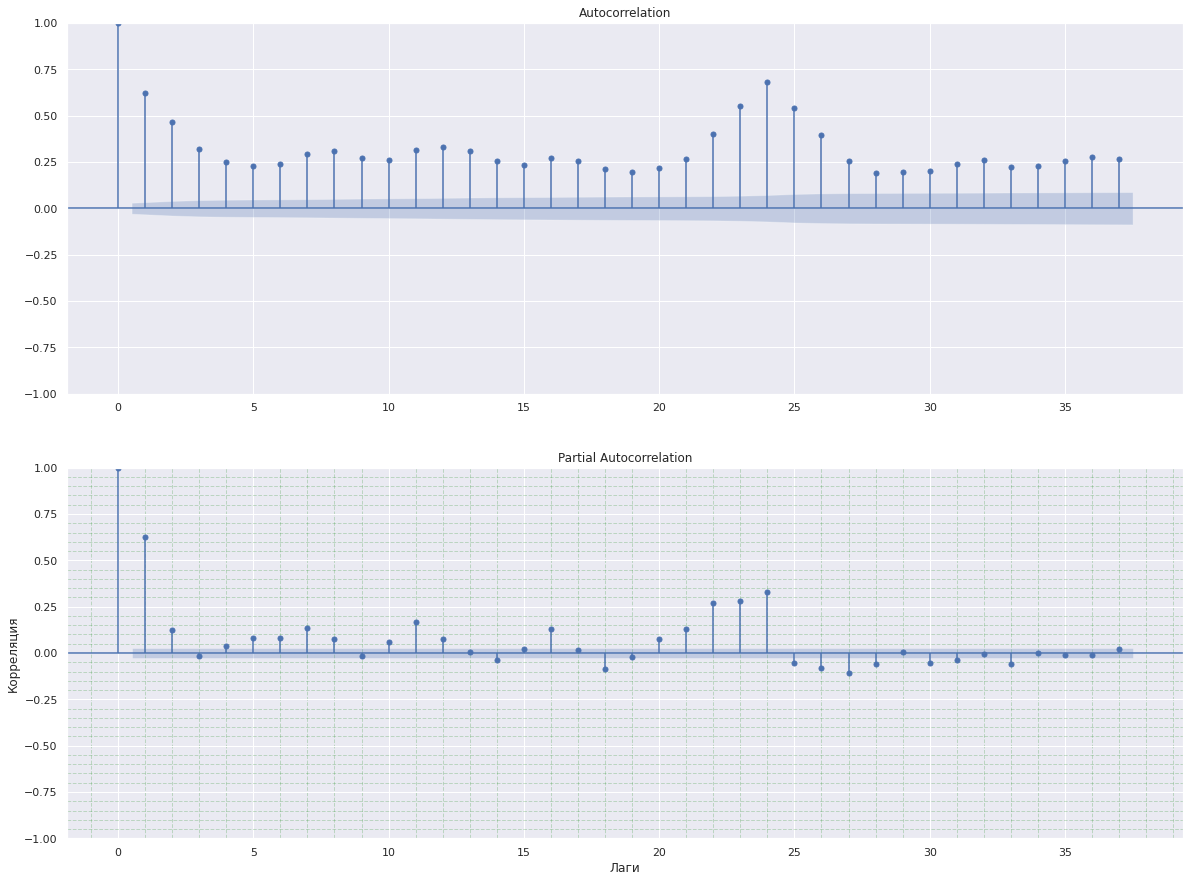

In [8]:
# Строим график
fig, ax = plt.subplots(2, figsize=(20, 15))
plot_acf(taxi['num_orders'], ax=ax[0])
plot_pacf(taxi['num_orders'], ax=ax[1], method='ywm')
plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
plt.minorticks_on()
plt.tick_params(which='minor')
plt.xlabel('Лаги')
plt.ylabel('Корреляция');

Мы видим, что 1-й, 2-й, 3-й и 24-й лаг имеют наибольшую корреляцию с наблюдениями во временном ряду.

In [9]:
# Раскладываем на составляющие
decomposed = seasonal_decompose(taxi['num_orders'], period=24)

In [10]:
# Функция для построения графика
def deсompose_plot(data, title):
    plt.figure(figsize=(15,7))
    data.plot()
    plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
    plt.minorticks_on()
    plt.tick_params(which='minor')
    plt.xticks(rotation = 25)
    plt.title(f'Графики {title} составляющей')
    plt.xlabel('Дата')
    plt.ylabel('Количество заказов');

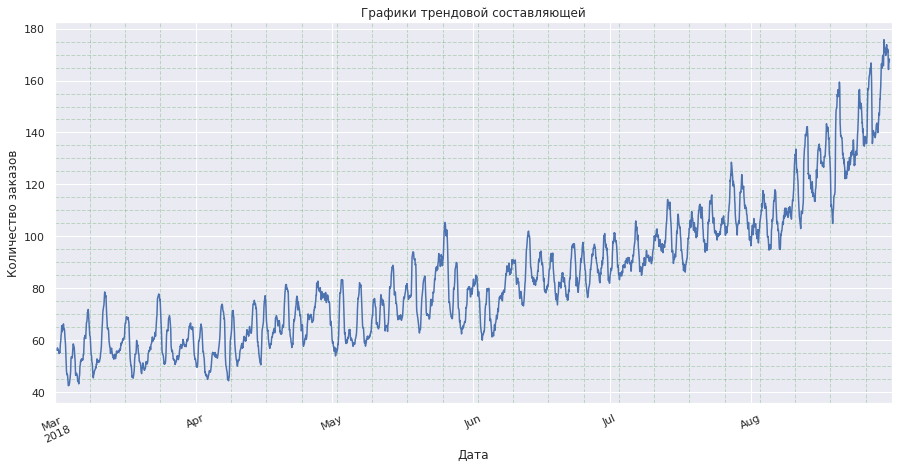

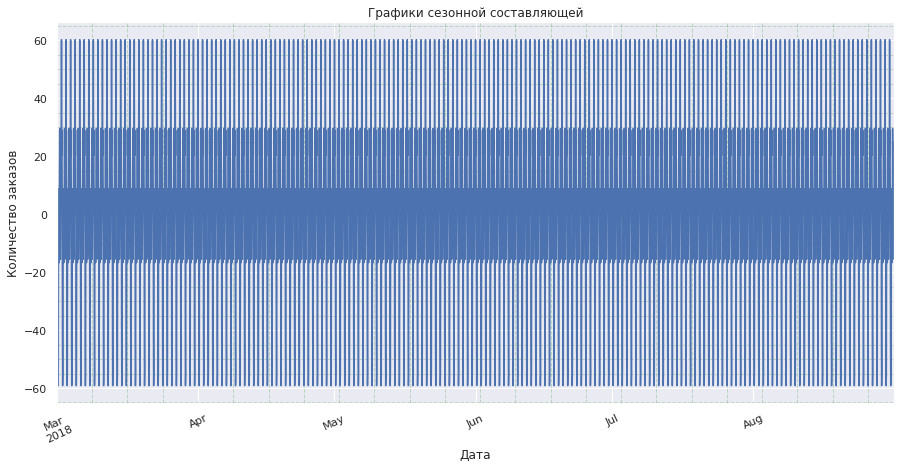

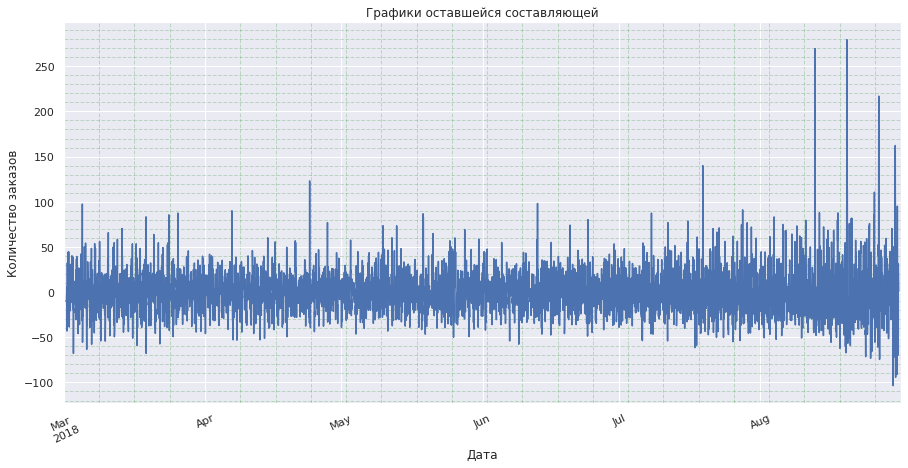

In [11]:
# Строим графики
deсompose_plot(decomposed.trend, 'трендовой')
deсompose_plot(decomposed.seasonal, 'сезонной')
deсompose_plot(decomposed.resid, 'оставшейся')

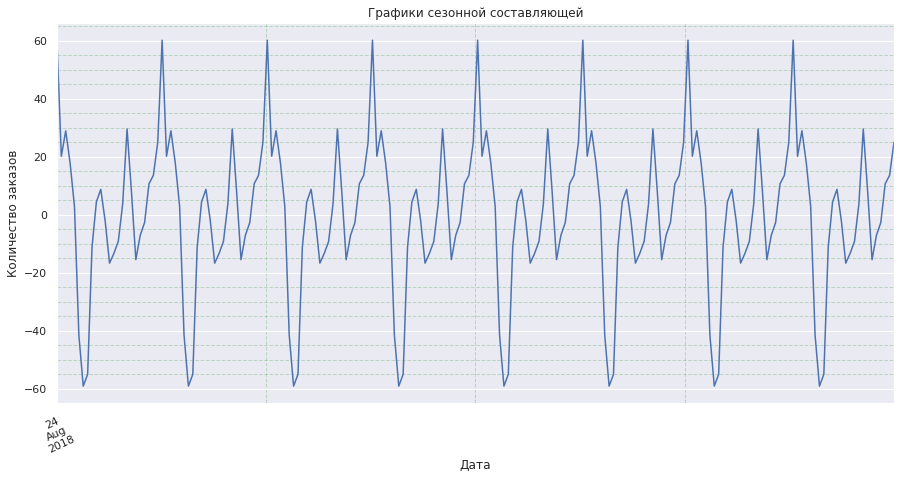

In [12]:
# Отдельно сезонность за неделю
deсompose_plot(decomposed.seasonal['2018-08-24':'2018-08-31'], 'сезонной')

Мы видим, что за полгода цены на такси в среднем увеличиваются, что нормально. 

Сезонность мы наблюдаем в среднем за 6 часов, в выходные роста цен нет.

Остатки имеют случайный характер и несколько пиков.

**Вывод:** таким образом, мы проанализировали график скользящего среднего, тренд, сезонность и остатки.

### **Подготовка данных**
<a id='preprocessing'></a>

#### Создание новых столбцов

Создадим признаки для дальнейшего прогнозирования в один шаг.

In [13]:
# Напишем функцию для создания признаков
def make_features(df):
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    
    lags = [1, 2, 3, 24]
    for lag in lags:
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)

In [14]:
# Создаем признаки
make_features(taxi)

In [15]:
general_info(taxi)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4416 non-null   int64  
 1   day         4416 non-null   int64  
 2   hour        4416 non-null   int64  
 3   dayofweek   4416 non-null   int64  
 4   lag_1       4415 non-null   float64
 5   lag_2       4414 non-null   float64
 6   lag_3       4413 non-null   float64
 7   lag_24      4392 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 310.5 KB


(4416, 8)

,num_orders,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_24
datetime,,,,,,,,
2018-03-01 00:00:00,124,1,0,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,2,3,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,1,4,3,66.0,71.0,85.0,NaN


True

(None, None)

**Вывод:** таким образом, мы создали признаки, которые помогут при обучении модели.

### **Обучение модели**
<a id='model'></a>

Разобьем признаки на тестовую и тренировочную выборки в соотношении 90:10.

In [16]:
train, test = train_test_split(taxi, shuffle=False, test_size=TEST_SIZE)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [17]:
# Проверим разбиение 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3950, 7), (3950,), (442, 7), (442,))

Создадим пайплайн для перебора моделей и гиперпараметров.

In [18]:
pipe = Pipeline(
    [
        ('models', LinearRegression())
    ]
)

Напишем словарь для подбора лучших гиперпараметров.

In [19]:
param_grid = [
    # словарь для модели LinearRegression() 
    {
        'models':[LinearRegression()]
    },
    
        # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 4),
        'models__min_samples_split':[2, 0.1, 0.2, 0.3],
        'models__min_samples_leaf':range(1, 5),
        'models__max_features': range(2,4)
    },
    
    # словарь для модель LGBMRegressor()
    {
        'models':[LGBMRegressor(random_state=RANDOM_STATE, verbosity=-1)],
        'models__n_estimators': [50, 100],
        'models__learning_rate': [0.01, 0.1, 0.2],
        'models__max_depth': [3, 5, 7]
    },
    
    # словарь для модели CatBoostRegressor()
    {
        'models':[CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)],
        'models__iterations': [50, 100],
        'models__learning_rate': [0.03, 0.05, 0.1],
        'models__max_depth': [3, 5, 7]
    }
    
]

Используем пайплайн и инструмент подбора гиперпараметров, чтобы выбрать лучшую модель. 

В качестве метрики возьмем RMSE.


In [20]:
# Производим подбор гиперпараметров с помощью RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    pipe, 
    param_grid,
    n_iter=15,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('models', LinearRegression())]),
                   n_iter=15, n_jobs=-1,
                   param_distributions=[{'models': [LinearRegression()]},
                                        {'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': range(2, 4),
                                         'models__max_features': range(2, 4),
                                         'models__min_samples_leaf': range(1, 5),
                                         'models__min_samples_split': [2, 0.1,
                                                                       0.2,
                                                                       0....
                                        {'models': [LGBMRegressor(random_state=42,
                                                                  verbosity=-1)],
                                         'models__learning_rate': [0.01, 0.1,
                                                                   0.2],
                                         'models__max_depth': [3, 5, 7],
                                         'models__n_estimators': [50, 100]},
                                        {'models': [<catboost.core.CatBoostRegressor object at 0x7f47915e1730>],
                                         'models__iterations': [50, 100],
                                         'models__learning_rate': [0.03, 0.05,
                                                                   0.1],
                                         'models__max_depth': [3, 5, 7]}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [21]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_,'\n',
      randomized_search.best_params_, '\n')
print ('Метрика лучшей модели на кросс-валидации:', abs(randomized_search.best_score_))

Лучшая модель и её параметры:

 Pipeline(steps=[('models',
                 LGBMRegressor(learning_rate=0.2, max_depth=3, n_estimators=50,
                               random_state=42, verbosity=-1))]) 
 {'models__n_estimators': 50, 'models__max_depth': 3, 'models__learning_rate': 0.2, 'models': LGBMRegressor(random_state=42, verbosity=-1)} 

Метрика лучшей модели на кросс-валидации: 24.39760426566386


**Вывод:** таким образом, мы перебрали несколько моделей и гиперпараметров и выбрали лучшую.

### **Тестирование модели**
<a id='testing'></a>

Проверим данные на тестовой выборке для лучшей модели.

In [22]:
y_test_pred = randomized_search.best_estimator_.predict(X_test)
print(f'Метрика RMSE на тестовой выборке: {np.sqrt(mean_squared_error(y_test, y_test_pred))}')

Метрика RMSE на тестовой выборке: 46.11898875270225


Метрика удовлетворяет требованиям заказчика. Проанализируем остатки.

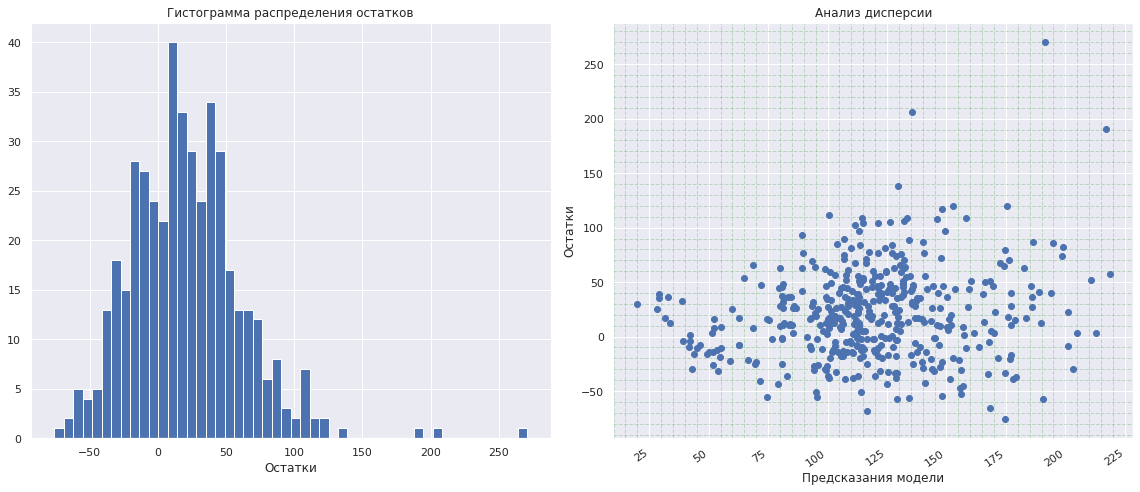

In [23]:
residuals = y_test-y_test_pred

# Построим графики по количественным признакам — гистограмму частотности распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,7))
axes[0].hist(residuals, bins=50)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(y_test_pred, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
plt.minorticks_on()
plt.tick_params(which='minor')
plt.xticks(rotation=35, ha='right')
plt.tight_layout()  
plt.show();

На гисторграмме график сдвинут вправо относительно нуля, значит модель чаще ошибается в большую сторону. 
Модель даёт в основном завышенные предсказания, такая модель работает не очень качественно.

На диаграмме рассеяния виднеется «рупор»: видно увеличение дисперсии при больших предсказаниях. Это говорит о непостоянстве предсказаний модели, поскольку она неравномерно ошибается.

**Вывод:** таким образом, мы построили модель, метрика которой удовлетворяет требованиям заказчика: RMSE = 46.

### **Итоговые выводы**
<a id='final'></a>

Таким образом мы выбрали лучшую модель для компании «Чётенькое такси»:

1. Построили модель для прогнозирования количество заказов такси на следующий час.

Для этого были выполнены следующие действия:

- **Открыт файл** с данными и изучена общая информация: 

**`/datasets/autos.csv`** содержал **4416 строк и 1 столбец**.


В данных пропуски отсутствовали, типы данных были корректны, даты и время расположены в хронологическом порядке. Мы имели дело с данными от 1 марта 2018 до 31 августа 2018 года.


- Выполнена **подготовка данных:**
    
    создали признаки для дальнейшего прогнозирования в один шаг.


- Провели **анализ данных:**

  проанализировали график скользящего среднего, тренд, сезонность и остатки.
  

- Применили пайплайны для подготовки признаков и обучения модели:

    перебирали гиперпараметры для моделей линейной регрессии и градиентного бустинга

- Выбрали лучшую модель, учитывая критерии заказчика (метрика RMSE < 48):

    **LightGBMRegressor(learning_rate=0.2, max_depth=3, n_estimators=50), RMSE = 46 на тестовой выборке.
    
    
**Рекомендации для бизнеса:** 

Использовать модель LightGBMRegressor(learning_rate=0.2, max_depth=3, n_estimators=50) с данными параметрами, она спрогнозирует количество заказов на следующий час с ошибкой 46 заказов. Это поможет привлекать больше водителей в период пиковой нагрузки.

